This notebook is meant to run on server where data has been downloaded.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from rtc_seq_dataset import SeqDistDataset, open_rtc_table, open_patch_table
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch

In [3]:
seed = torch.Generator().manual_seed(42)

In [4]:
%%time

df_patch = open_patch_table()
df_rtc = open_rtc_table()

CPU times: user 31.3 s, sys: 13.8 s, total: 45.2 s
Wall time: 45.3 s


This cell is what needs modification if running notebook elsewhere:

- `root` is where data is downloaded
- `download` is `True` indicates looking for data

The dataset basically checks if data already exists and this takes a few minutes if data has been previous downloaded to compile the columns of paths based on `root`.

In [5]:
%%time

seq_dataset = SeqDistDataset(download=True, 
                             n_pre_imgs=4, 
                             patch_table=df_patch, 
                             rtc_table=df_rtc,
                             root='../6_torch_dataset/opera_rtc_data')

downloading vh: 100%|██████████████████████████████████████████| 237853/237853 [00:44<00:00, 5299.46it/s]


CPU times: user 1min 10s, sys: 25.7 s, total: 1min 36s
Wall time: 1min 50s


In [6]:
for i, data in enumerate(seq_dataset):
    break

# data

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


In [14]:
def collate_fn(batch):
    pre_imgs_b = torch.stack([item['pre_imgs'] for item in batch], dim=0).float()
    post_img_b = torch.stack([item['post_img'] for item in batch], dim=0).float()
    nodata_mask_b = torch.stack([item['nodata_masks'] for item in batch], dim=0)

    out = {'pre_imgs': pre_imgs_b,
           'post_img': post_img_b,
           'nodata_masks':  nodata_mask_b,
           }
    return out

In [15]:
%%time

train_dataset, val_dataset, test_dataset = random_split(seq_dataset, [.6, .2, .2], generator=seed)

CPU times: user 1min 1s, sys: 42 s, total: 1min 43s
Wall time: 54.4 s


In [16]:
%%time

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

CPU times: user 2.69 s, sys: 1.79 s, total: 4.48 s
Wall time: 4.46 s


In [17]:
%%time
dl = iter(train_dataloader)

CPU times: user 288 μs, sys: 141 μs, total: 429 μs
Wall time: 312 μs


The first next takes longest - not sure what the bottleneck is at initialization.

In [18]:
%%time

batch = next(dl)

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.59it/s]

CPU times: user 52.1 s, sys: 23.5 s, total: 1min 15s
Wall time: 37.4 s


In [19]:
%%time
pre_imgs = batch['pre_imgs'].cpu().numpy()
nodata_masks = batch['nodata_masks'].cpu().numpy()

CPU times: user 56.7 ms, sys: 0 ns, total: 56.7 ms
Wall time: 599 μs


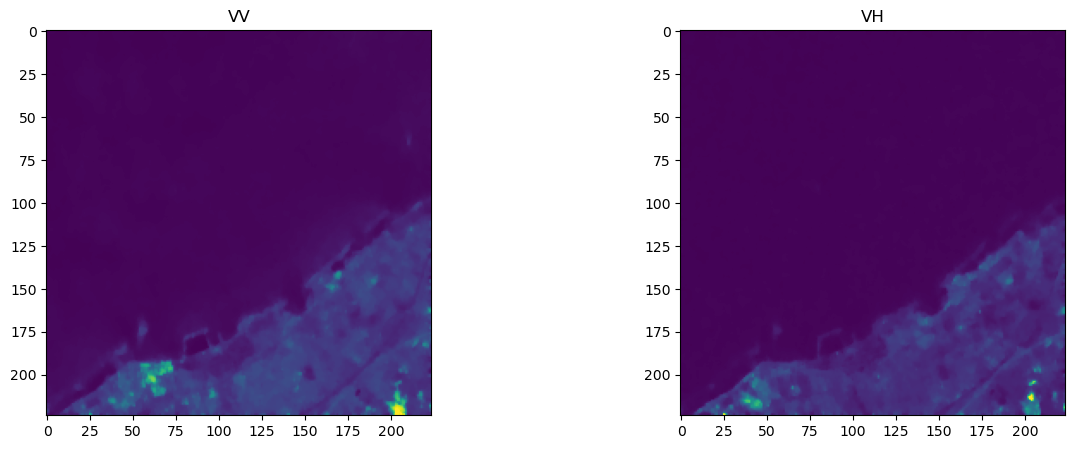

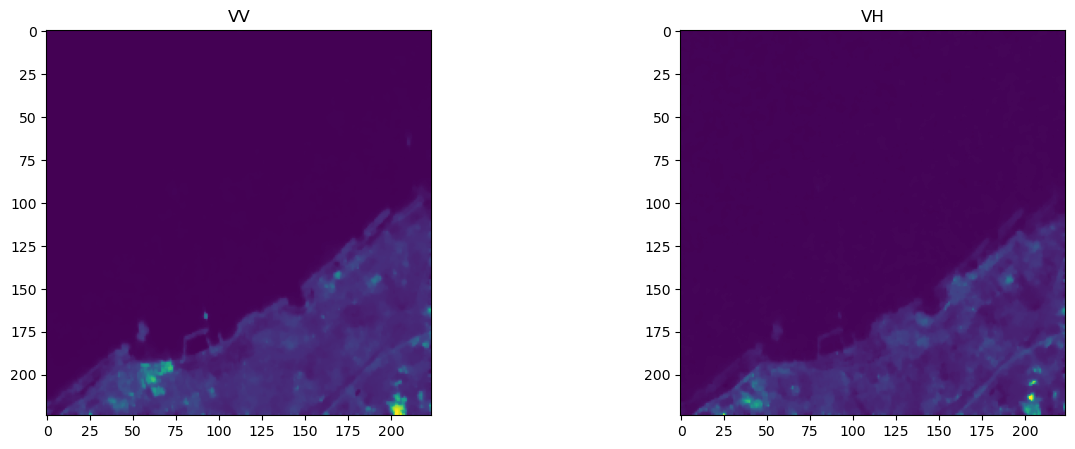

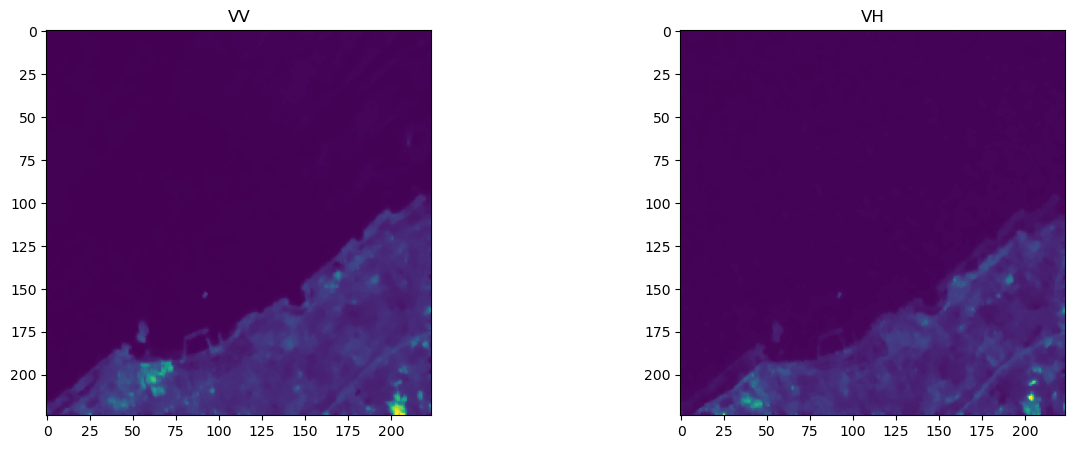

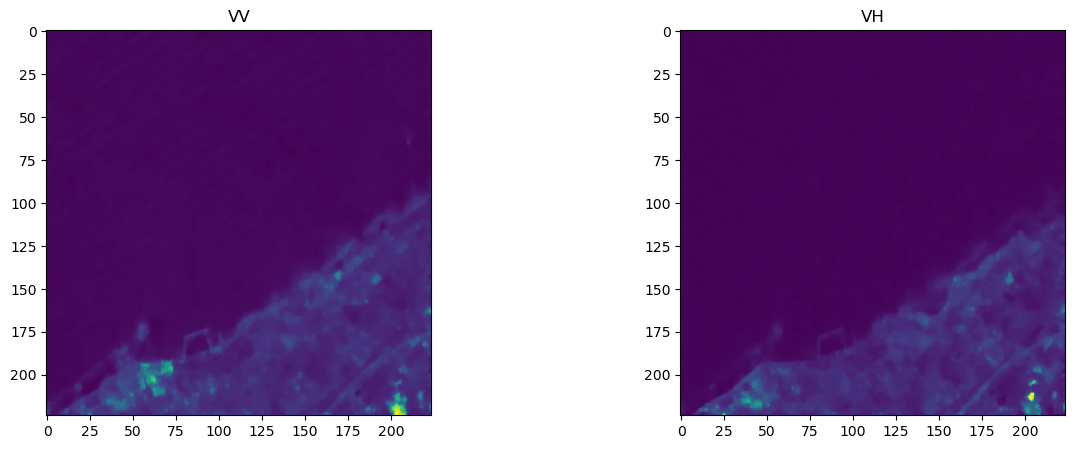

In [21]:
batch_ind = 2

for pre_img_ind in range(4):
    m = nodata_masks[batch_ind, ...].any(axis=0)
    vv = pre_imgs[batch_ind, pre_img_ind, 0, ...]
    vh = pre_imgs[batch_ind, pre_img_ind, 1, ...]

    vv[m] = np.nan
    vh[m] = np.nan
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(vv, vmin=0, vmax=.7)
    axs[0].set_title('VV')
    axs[1].imshow(vh, vmin=0, vmax=.15)
    axs[1].set_title('VH')
    plt.show()

## Unet

In [22]:
import pytorch_lightning as pl
from unet import Unet

In [23]:
decoder_channels = [int(224 / 2** i) for i in range(5)]
decoder_channels

[224, 112, 56, 28, 14]

In [30]:
MODEL = Unet(backbone='resnet50',
             backbone_kwargs=None,
             backbone_indices=None,
             decoder_use_batchnorm=True,
             decoder_channels=decoder_channels,
             in_chans= seq_dataset.n_pre_imgs * 2,
             # Two polarizations out
             num_classes=2
            )

In [32]:
decoder_channels = [int(224 / 2** i) for i in range(5)]
decoder_channels

[224, 112, 56, 28, 14]

In [44]:
import torch.nn.functional as F

class UnetAutoencoder(pl.LightningModule):
    def __init__(self, ):
        super().__init__()
        model = Unet(backbone='resnet50',
                     backbone_kwargs=None,
                     backbone_indices=None,
                     decoder_use_batchnorm=True,
                     decoder_channels=decoder_channels,
                     in_chans= seq_dataset.n_pre_imgs * 2, 
                     num_classes=2)
        self.unet = model

    def training_step(self, batch, batch_idx):
        pre_imgs = batch['pre_imgs']
        post_img = batch['post_img']
        mask = batch['nodata_masks']
        
        # preimgs are B X T X 2 X H X W --> B X (T * 2) X H X W
        x_hat = self.unet(pre_imgs.flatten(1, 2))
        loss = F.mse_loss(x_hat, post_img)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [45]:
l_model = UnetAutoencoder()

In [46]:
# train model
trainer = pl.Trainer()
trainer.fit(model=l_model, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/u/aurora-r0/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params | Mode 
--------------------------------------
0 | unet | Unet | 31.3 M | train
--------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.125   Total estimated model params size (MB)
/u/aurora-r0/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=223` in the `DataLoader` to improve performance.


Training: |                                                                        | 0/? [00:00<?, ?it/s]


loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.61it/s]

loading vh: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.22it/s]

tv for vv: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.63it/s]

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.54it/s]

loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]

loading vh: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]

tv for vv: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.22it/s]

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.38it/s]

loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.81it/s]

loading vh: 100%|███████████████████

torch.Size([4, 2, 224, 224]) torch.Size([4, 2, 224, 224])



loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]

loading vh: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.32it/s]

tv for vv: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.36it/s]

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.58it/s]

loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.67it/s]

loading vh: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.92it/s]

tv for vv: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.35it/s]

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.58it/s]

loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.38it/s]

loading vh:   0%|                   